In [22]:
import pandas as pd
from sklearn.model_selection import (
    StratifiedShuffleSplit, GridSearchCV, 
    train_test_split, cross_validate, cross_val_score
)
from lightgbm import LGBMClassifier
from sklift.models import SoloModel
from sklift.viz import plot_qini_curve
from sklift.datasets import fetch_megafon
from sklift.metrics import make_uplift_scorer
import os
import sys
from pathlib import Path
import yaml
from datetime import datetime
import re

In [23]:
cwd = Path.cwd()
repo_root = ([cwd] + list(cwd.parents))[1]

# Ensure repo_root is on sys.path so `src.train` can be imported
sys.path.append(str(repo_root))
from src.process_datasets import create_data, get_web_feats

# Load the YAML config file
with open(os.path.join(repo_root, "config.yaml"), "r") as f:
    config = yaml.safe_load(f)

In [24]:
def clean_column_names(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans column names: replaces whitespace with underscores,
    removes special characters, and ensures valid Python identifiers.
    """
    new_columns = []
    for col in df.columns:
        # 1. Replace whitespace with underscores
        clean_col = re.sub(r"\s+", "_", col)
        # 2. Remove non-alphanumeric characters except underscore
        clean_col = re.sub(r"[^\w]", "", clean_col)
        # 3. Ensure it doesn't start with a number
        if re.match(r"^\d", clean_col):
            clean_col = "_" + clean_col
        new_columns.append(clean_col)
    df.columns = new_columns
    return df

In [25]:
X_train, y_train, X_test, y_test, train, test = create_data(repo_root, config)
for df in [X_train, X_test]:
    df = clean_column_names(df)
y_train = train["churn"].astype(int)
treatment_train = train["outreach"].astype(int)

y_test = test["churn"].astype(int)
treatment_test = test["outreach"].astype(int)

print(f"\nTraining data: {len(X_train)} samples; test data: {len(X_test)} samples")
print(
    f"Treatment in train: {treatment_train.sum()} / {len(treatment_train)} ({100*treatment_train.mean():.1f}%)"
)
print(
    f"Treatment in test: {treatment_test.sum()} / {len(treatment_test)} ({100*treatment_test.mean():.1f}%)"
)

# Choose uplift method (two-model vs meta-learner S-learner)
uplift_method = config.get("uplift_method", "two_model")
models_dir = os.path.join(repo_root, "models")
os.makedirs(models_dir, exist_ok=True)
outputs_dir = os.path.join(repo_root, "outputs")
os.makedirs(outputs_dir, exist_ok=True)
timestamp = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")

Aggregating train features...
Aggregating test features...
Training data: 10000 samples; test data: 10000 samples

Training data: 10000 samples; test data: 10000 samples
Treatment in train: 3984 / 10000 (39.8%)
Treatment in test: 3889 / 10000 (38.9%)


In [26]:
from datetime import datetime

In [27]:
# dataset = fetch_megafon()
# data, treatment, target = dataset.data, dataset.treatment, dataset.target
# data = data.set_index('id')
X_train.drop(columns=["outreach"], inplace=True)
X_test.drop(columns=["outreach"], inplace=True)
X_train.head()

C:\Users\elad\AppData\Local\Temp\ipykernel_15868\3304880680.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(columns=["outreach"], inplace=True)
C:\Users\elad\AppData\Local\Temp\ipykernel_15868\3304880680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(columns=["outreach"], inplace=True)


,days_already_on_app,session_count,web_visit_count,claims_count,has_E11_9,has_I10,has_Z71_3
0,445,6.0,3.0,9.0,1.0,1.0,1.0
1,112,10.0,9.0,9.0,1.0,1.0,1.0
2,277,9.0,52.0,4.0,1.0,0.0,0.0
3,441,10.0,15.0,5.0,0.0,1.0,0.0
4,476,10.0,11.0,7.0,1.0,1.0,1.0


---

### 1) Conditional Independence Assumption:

intuition: check if treatment was random

In [28]:
f1_micro = cross_val_score(
    X=X_train,
    y=treatment_train,
    estimator=LGBMClassifier(random_state=42, n_jobs=-1),
    scoring="f1_micro",
    cv=3,
)

print(f'F1 micro {f1_micro.mean():.2f}')

[LightGBM] [Info] Number of positive: 2656, number of negative: 4010
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 6666, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.398440 -> initscore=-0.411970
[LightGBM] [Info] Start training from score -0.411970
[LightGBM] [Info] Number of positive: 2656, number of negative: 4011
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 395
[LightGBM] [Info] Number of data points in the train set: 6667, number of used features: 7
[LightGBM] [Info] [binary:Bo

In [29]:
X_train.groupby(treatment_train).mean()

,days_already_on_app,session_count,web_visit_count,claims_count,has_E11_9,has_I10,has_Z71_3
outreach,,,,,,,
0,294.287733,10.480386,25.772773,6.448637,0.589761,0.589761,0.585439
1,282.533133,8.719629,26.177460,6.471135,0.585341,0.587098,0.595884


Based on the user's features, the classifier makes type I and type II errors as often (50%) as it guesses the correct answer. This means that communication was carried out by random.

### 2) Fit single model with treatment feature (S-Learner approach) ([link to tutorial](https://habr.com/ru/company/ru_mts/blog/485980/))

intuition: the model fits simultaneously on two groups with binary treatment flag as an additional user's feature. We score each object from the test sample twice: with the treatment flag equal to 1 and equal to 0. Subtracting the probabilities for each observation, we obtain an estimated uplift.

In [30]:
# setting up model ...
estimator = LGBMClassifier(random_state=42, n_jobs=-1, class_weight="balanced")

# ... metamodel ...
slearner = SoloModel(estimator=estimator)

# ... and uplift metric scorer to pass to cross validation
uplift_scorer = make_uplift_scorer("qini_auc_score", treatment_train)

In [31]:
cv_gen = StratifiedShuffleSplit(
    n_splits=3,
    random_state=42
)

cross_validate(
    slearner,
    X=X_train,
    y=y_train,
    scoring=uplift_scorer,
    return_estimator=True,
    cv=cv_gen,
    n_jobs=-1,
    fit_params={"treatment": treatment_train},
)

{'fit_time': array([0.25788665, 0.27681088, 0.30054331]),
 'score_time': array([0.00866747, 0.00745201, 0.01471996]),
 'estimator': [SoloModel(estimator=LGBMClassifier(class_weight='balanced', n_jobs=-1,
                                     random_state=42)),
  SoloModel(estimator=LGBMClassifier(class_weight='balanced', n_jobs=-1,
                                     random_state=42)),
  SoloModel(estimator=LGBMClassifier(class_weight='balanced', n_jobs=-1,
                                     random_state=42))],
 'test_score': array([ 0.03960618, -0.0618611 ,  0.04956846])}

In [32]:
grid = {
    "estimator__learning_rate": [ 0.05, 0.1],
    "estimator__max_depth": [6, 8,16,32],
}

grid_search = GridSearchCV(slearner,
                           param_grid=grid,
                           scoring=uplift_scorer,
                           n_jobs=-1,
                           cv=cv_gen,
                           return_train_score=True
                          )

grid_search = grid_search.fit(X=X_train, y=y_train, treatment=treatment_train)

[LightGBM] [Info] Number of positive: 2021, number of negative: 7979
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 404
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [33]:
print(f"best qini score on grid search: {grid_search.best_score_:.4f}")
print(f"best params: {grid_search.best_params_}")

best qini score on grid search: 0.0176
best params: {'estimator__learning_rate': 0.05, 'estimator__max_depth': 8}


In [34]:
slearner.set_params(**grid_search.best_params_)

slearner.fit(
    X=X_train, 
    y=y_train, 
    treatment=treatment_train,
)
uplift = slearner.predict(X_test)

[LightGBM] [Info] Number of positive: 2021, number of negative: 7979
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 404
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Text(0.5, 0.98, 'Qini curve')

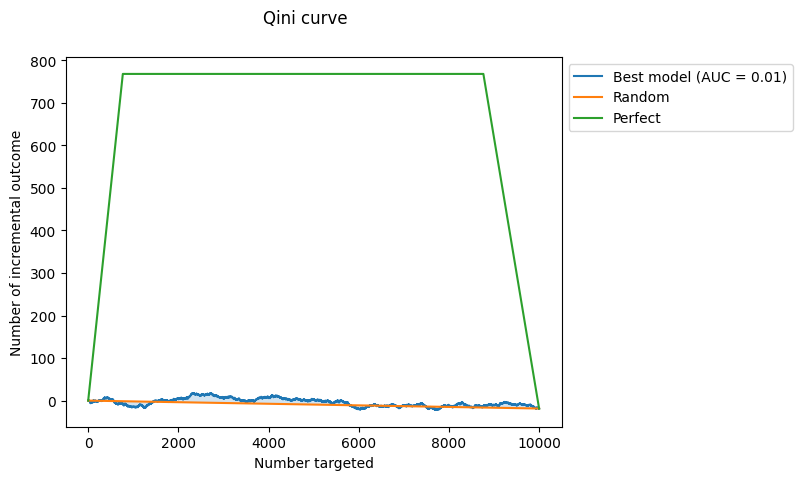

In [35]:
bets_disp = plot_qini_curve(
    y_test, uplift, treatment_test, perfect=True, name="Best model"
)
bets_disp.figure_.suptitle("Qini curve")

Params: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100} | CV Qini AUC: -0.0185
Params: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 200} | CV Qini AUC: -0.0188
Params: {'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100} | CV Qini AUC: -0.0185
Params: {'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 200} | CV Qini AUC: -0.0188
Params: {'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 100} | CV Qini AUC: -0.0192
Params: {'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 200} | CV Qini AUC: -0.0191
Params: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100} | CV Qini AUC: -0.0176
Params: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200} | CV Qini AUC: -0.0174
Params: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100} | CV Qini AUC: -0.0192
Params: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200} | CV Qini AUC: -0.0184
Params: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 10

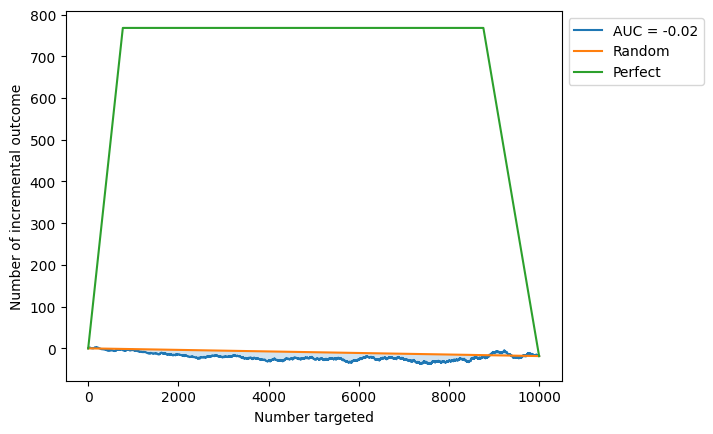

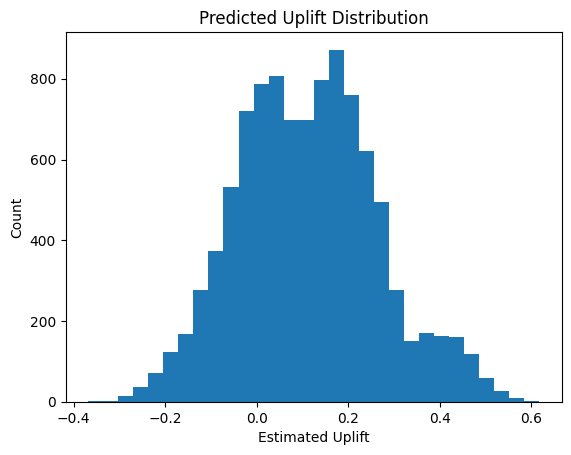

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
from sklift.models import ClassTransformation
from sklift.metrics import qini_auc_score
from sklift.viz import plot_qini_curve
from sklearn.model_selection import StratifiedKFold

# --- 1. Define base model and parameter grid ---
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 8],
    "min_samples_split": [2, 5, 10],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

best_score = -np.inf
best_params = None

# --- 2. Manual cross-validation loop ---
for params in ParameterGrid(param_grid):
    cv_scores = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        treat_tr, treat_val = (
            treatment_train.iloc[train_idx],
            treatment_train.iloc[val_idx],
        )

        uplift_model = ClassTransformation(
            estimator=RandomForestClassifier(random_state=42, **params)
        )
        uplift_model.fit(X_tr, y_tr, treat_tr)

        uplift_preds = uplift_model.predict(X_val)
        qini = qini_auc_score(y_val, uplift_preds, treat_val)
        cv_scores.append(qini)

    mean_qini = np.mean(cv_scores)

    print(f"Params: {params} | CV Qini AUC: {mean_qini:.4f}")

    if mean_qini > best_score:
        best_score = mean_qini
        best_params = params

print("✅ Best Params:", best_params)
print("✅ Best CV Qini AUC:", best_score)

# --- 3. Train best model on all training data ---
final_model = ClassTransformation(
    estimator=RandomForestClassifier(random_state=42, **best_params)
)
final_model.fit(X_train, y_train, treatment_train)

# --- 4. Evaluate on test data ---
uplift_preds = final_model.predict(X_test)
test_qini = qini_auc_score(y_test, uplift_preds, treatment_test)

print(f"📈 Test Qini AUC: {test_qini:.4f}")

# --- 5. Plot Qini curve ---
plot_qini_curve(y_test, uplift_preds, treatment_test)

# --- 6. Optional: show uplift distribution ---
plt.figure()
plt.hist(uplift_preds, bins=30)
plt.title("Predicted Uplift Distribution")
plt.xlabel("Estimated Uplift")
plt.ylabel("Count")
plt.show()

In [37]:
print(train.groupby("outreach")["churn"].mean())

outreach
0    0.207447
1    0.194026
Name: churn, dtype: float64


📈 Fixed Test Qini AUC: 0.0160


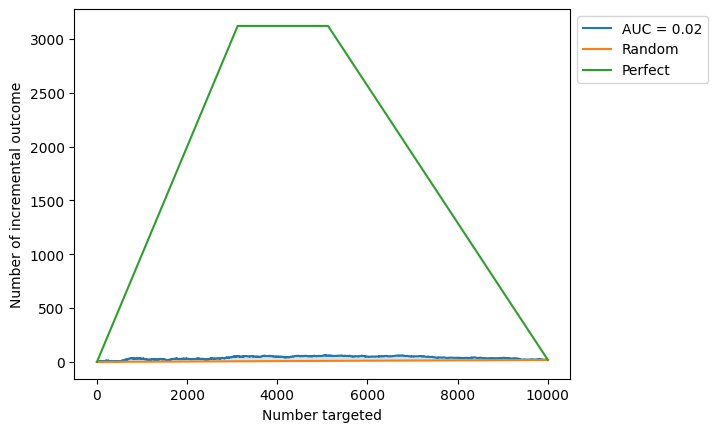

In [38]:
# Flip target so that 1 = retained (good outcome)
y_train_adj = 1 - y_train
y_test_adj = 1 - y_test

# Refit your best model
final_model.fit(X_train, y_train_adj, treatment_train)

uplift_preds = final_model.predict(X_test)
test_qini = qini_auc_score(y_test_adj, uplift_preds, treatment_test)

print(f"📈 Fixed Test Qini AUC: {test_qini:.4f}")
plot_qini_curve(y_test_adj, uplift_preds, treatment_test)

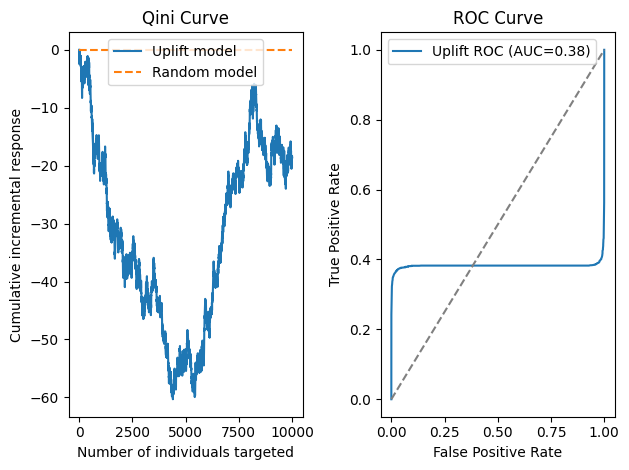

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ---------------------------
#  dataset
# ---------------------------
X=X_train
treatment=treatment_train
y=y_train
# ---------------------------
# 1. Propensity score estimation
# ---------------------------
prop_model = LogisticRegression(max_iter=1000)
prop_model.fit(X, treatment)
propensity_scores = prop_model.predict_proba(X)[:, 1]

# ---------------------------
# 2. Train separate outcome models (T-learner)
# ---------------------------
weights_treated = 1 / propensity_scores
weights_control = 1 / (1 - propensity_scores)

model_treated = RandomForestClassifier(n_estimators=100, random_state=42)
model_treated.fit(
    X[treatment == 1], y[treatment == 1], sample_weight=weights_treated[treatment == 1]
)

model_control = RandomForestClassifier(n_estimators=100, random_state=42)
model_control.fit(
    X[treatment == 0], y[treatment == 0], sample_weight=weights_control[treatment == 0]
)

# ---------------------------
# 3. Predict outcomes under treatment and control
# ---------------------------
y_pred_treated = model_treated.predict_proba(X_test)[:, 1]
y_pred_control = model_control.predict_proba(X_test)[:, 1]

uplift_scores = y_pred_treated - y_pred_control


# ---------------------------
# 4. Qini curve
# ---------------------------
def qini_curve(y, treatment, uplift):
    """Compute Qini curve points"""
    df = pd.DataFrame({"y": y, "t": treatment, "uplift": uplift})
    df = df.sort_values("uplift", ascending=False)

    cum_treated = df["t"].cumsum()
    cum_control = (~df["t"].astype(bool)).cumsum()

    cum_outcome_treated = (df["y"] * df["t"]).cumsum()
    cum_outcome_control = (df["y"] * (1 - df["t"])).cumsum()

    # Qini: difference in cumulative outcomes scaled by group sizes
    qini = cum_outcome_treated - cum_outcome_control * (
        cum_treated / np.maximum(cum_control, 1)
    )
    return qini


qini = qini_curve(y_test, treatment_test, uplift_scores)


# Qini curve subplot
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, len(qini) + 1), qini, label="Uplift model")
plt.plot([0, len(qini)], [0, qini.max()], "--", label="Random model")
plt.xlabel("Number of individuals targeted")
plt.ylabel("Cumulative incremental response")
plt.title("Qini Curve")
plt.legend()

# ROC curve subplot
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, label=f"Uplift ROC (AUC={roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

plt.tight_layout()
plt.show()

In [48]:
X

,days_already_on_app,session_count,web_visit_count,claims_count,has_E11_9,has_I10,has_Z71_3
0,445,6.0,3.0,9.0,1.0,1.0,1.0
1,112,10.0,9.0,9.0,1.0,1.0,1.0
2,277,9.0,52.0,4.0,1.0,0.0,0.0
3,441,10.0,15.0,5.0,0.0,1.0,0.0
4,476,10.0,11.0,7.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...
9995,302,8.0,18.0,9.0,1.0,0.0,1.0
9996,510,11.0,8.0,5.0,1.0,0.0,1.0
9997,303,12.0,8.0,14.0,0.0,0.0,1.0
9998,527,7.0,36.0,6.0,0.0,0.0,1.0


In [40]:
X

,days_already_on_app,session_count,web_visit_count,claims_count,has_E11_9,has_I10,has_Z71_3
0,445,6.0,3.0,9.0,1.0,1.0,1.0
1,112,10.0,9.0,9.0,1.0,1.0,1.0
2,277,9.0,52.0,4.0,1.0,0.0,0.0
3,441,10.0,15.0,5.0,0.0,1.0,0.0
4,476,10.0,11.0,7.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...
9995,302,8.0,18.0,9.0,1.0,0.0,1.0
9996,510,11.0,8.0,5.0,1.0,0.0,1.0
9997,303,12.0,8.0,14.0,0.0,0.0,1.0
9998,527,7.0,36.0,6.0,0.0,0.0,1.0
